In [ ]:
import os
print(os.listdir("../input"))

vvv KEVIN vvvv

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

import keras
import tensorflow as tf


from keras.preprocessing import image
from keras.utils import to_categorical

from keras.applications.resnet50 import ResNet50,preprocess_input

from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten,BatchNormalization,Activation
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.layers as L

from keras.optimizers import Adam, SGD, RMSprop
from tensorflow.python.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import cv2

import matplotlib.pyplot as plt


from kaggle_datasets import KaggleDatasets

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [21]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')

# Configuration
EPOCHS = 3
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [224, 224]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')

In [22]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        #"class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    #label = tf.cast(example['class'], tf.int32)
    label = tf.cast(example['target'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [23]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

TRAIN_STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} test images'.format(NUM_TRAINING_IMAGES, NUM_TEST_IMAGES))

Dataset: 33126 training images, 10982 test images


In [24]:
# Defining the optimizer and compiling the model
with strategy.scope():
    model = Sequential()
    model.add(ResNet50(include_top=False,input_tensor=None,input_shape=(224,224,3),pooling='avg',classes=2, weights= 'imagenet'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.layers[0].trainable = False
    
    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=[tf.keras.metrics.AUC()]
    )
    
    model.summary()

    
    

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

In [25]:
#get and print traning data
train_data = get_training_dataset()
print(train_data)



<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


In [26]:
#FIT AND SAVE MODEL

# Fitting the model
history = model.fit(
    train_data,
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    epochs=EPOCHS,
    #validation_data=get_validation_dataset(),
    #validation_steps=VAL_STEPS_PER_EPOCH
)

Epoch 1/3
517/517 [==============================] - 25s 49ms/step - loss: 0.1974 - auc_2: 0.4931
Epoch 2/3
517/517 [==============================] - 22s 43ms/step - loss: 0.1006 - auc_2: 0.5017
Epoch 3/3
517/517 [==============================] - 22s 43ms/step - loss: 0.0979 - auc_2: 0.4942


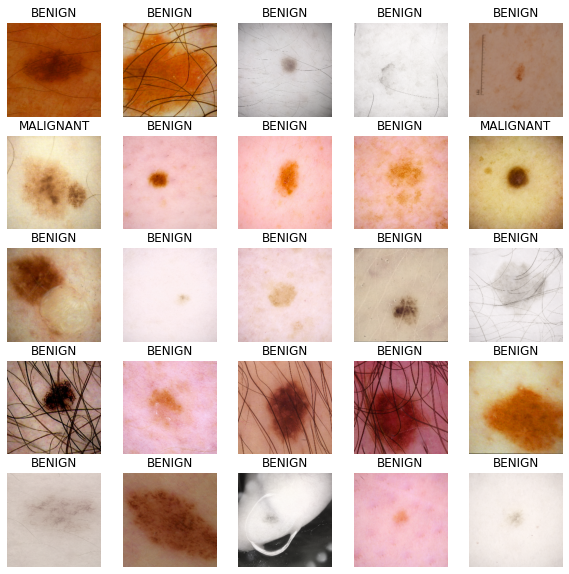

In [35]:
#print train set with label
train_dataset = get_training_dataset()
test_dataset = get_test_dataset()

image_batch, label_batch = next(iter(train_dataset))


def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("MALIGNANT")
        else:
            plt.title("BENIGN")
        plt.axis("off")


show_batch(image_batch.numpy(), label_batch.numpy())

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>


/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


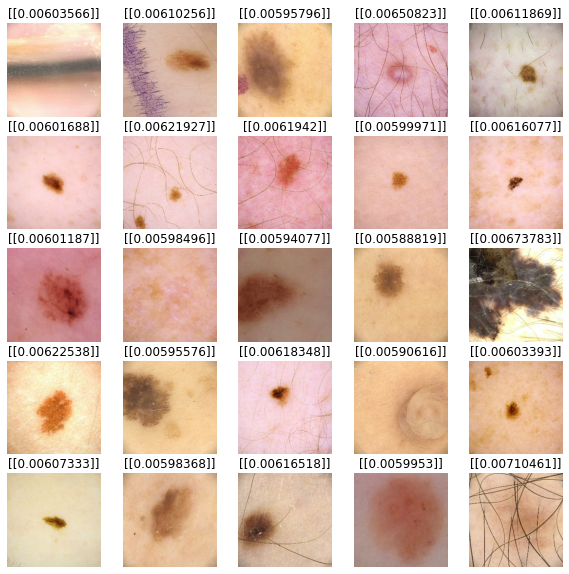

In [34]:
#get testing data
test_dataset = get_test_dataset()
print(test_dataset)

#test model
def show_batch_predictions(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        img_array = tf.expand_dims(image_batch[n], axis=0)
        plt.title(model.predict(img_array))
        plt.axis("off")

image_batch, label_batch = next(iter(test_dataset))
        
#print(image_batch)
show_batch_predictions(image_batch)

In [ ]:
#Predict and plot ROC(must use train set for validation label)
from sklearn.metrics import roc_curve, roc_auc_score

test_ds = get_training_dataset()


def show_batch(image_batch, label_batch):
    #plt.figure(figsize=(10, 10))
    predictions = []
    labels = []
    for n in range(64):
        #ax = plt.subplot(5, 5, n + 1)
        #plt.imshow(image_batch[n])
        #transform image 
        img_array = tf.expand_dims(image_batch[n], axis=0)
        #grab predictions and true label
        predictions.append(model.predict(img_array))
        labels.append(label_batch[n])
        #if label_batch[n]:
            #plt.title("MALIGNANT")
        #else:
            #plt.title("BENIGN")
        #plt.axis("off")
    return predictions, labels

for i in range(20):
    image_batch, label_batch = next(iter(test_ds))
    y_probs, y_true = show_batch(image_batch.numpy(), label_batch.numpy())
    
#convert to int
pred= []
for n in range(64):
    x= int(y_probs[n])
    pred.append(x)

r_probs = [0 for _ in range(len(y_true))]
rf_probs = pred
print(rf_probs)

#keep positive values(useless since we only have 1 class fml)
#rf_probs = rf_probs[:, 1]

r_auc = roc_auc_score(y_true, r_probs)
rf_auc = roc_auc_score(y_true, rf_probs)

print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Reznet Prediction: AUROC = %.3f' % (rf_auc))

r_fpr, r_tpr, _ = roc_curve(y_true, r_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_true, rf_probs)

plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Reznet prediction (AUROC = %0.3f)' % rf_auc)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()


In [32]:
###PREDICT A SINGLE GIVEN IMAGE

print('Computing predictions...')
path1 = '../input/singlet/AUG_0_1001.jpg'
path2 = '../input/singlet/ISIC_0076742.jpg' #benign
path3 = '../input/singlet/ISIC_0149568.jpg' #malignent  
imag = image.load_img(path3, target_size=(224,224))
img_arr = image.img_to_array(imag)
img_batch = np.expand_dims(img_arr, axis=0)
im = tf.cast(img_batch, tf.float32) / 255.0
#im = mp.asarray(im)
probability = model.predict(im)

print('Prediction: ', probability)

Computing predictions...
Prediction:  [[0.00593472]]


In [33]:
###PREDICT ON SET A CREATE CSV FILE OUTPUT

#PREDICT
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch

pred_df = pd.DataFrame({'image_name': test_ids, 'predicted': np.concatenate(probabilities)})
pred_df.head()



Computing predictions...
Generating submission.csv file...


,image_name,predicted
0,ISIC_6381819,0.006038
1,ISIC_5583376,0.006059
2,ISIC_6408546,0.006093
3,ISIC_6932354,0.006063
4,ISIC_8191278,0.006335
